# Imports and loading dataset

### Financial tweets data:
Filtered twitter data for text classification. Consists of the following columns
* `date`: The date when the tweet was posted
* `symbol`: The symbol the tweet is associated with, by using '$symbol' as the query for the search API
* `tweet`: Full text data of the tweet
* `id`: Tweet id of the tweet

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from wordcloud import WordCloud

df = pd.read_csv("../input/financial-tweets-and-stock-prices/filtered_tweets.csv", dtype={'id': 'string'})
df

,date,symbol,tweet,id
0,2021-05-17,GM,we closed this $gm position for a 37% #profit 👍,<NA>
1,2021-05-17,GM,$gm dfly. let’s get it !#greenteam,<NA>
2,2021-05-17,UAL,united airlines ( $ual ) will add more than 40...,<NA>
3,2021-05-17,UAL,"united adding 400+ daily flights in july, says...",<NA>
4,2021-05-17,UAL,#unitedairlines adds more flights on rising #t...,<NA>
...,...,...,...,...
19525,2021-06-15,WISH,$wish great open!,1404793673594908677
19526,2021-06-15,WISH,$wish,1404794478658035720
19527,2021-06-16,FB,$fb set to begin testing ads inside oculus vir...,1405242025826529284
19528,2021-06-16,GM,why says general motors ( $gm ) is a 'winner' 👀,1405209143162646533


Let us get the utility functions from previous notebooks for visualisation purposes

In [2]:
# Print 5 sample tweets from the dataframe, along with its associated symbol
# and the link to the original tweet if the id exists
def print_tweets(df):
    sample = df.sample(n=5, random_state=43)
    for _, row in sample.iterrows():
        print(f"Symbol: {row.symbol}")
        if type(row.id) == str:
            print(f"Link: https://twitter.com/user/status/{row.id}")
        print(f"Text: {row.tweet}")
        print("==============================")  

In [3]:
def get_wordcloud(df):
    text_data = " ".join(text for text in df['tweet'])
    wordcloud = WordCloud(max_font_size=50, background_color="white").generate(text_data)
    return wordcloud

## Label the data using change in stock prices

Given the large amount of data, we want to classify each tweet as either having a bullish or bearish sentiment. While there are general sentiment classifiers out there, their classification are based on general statements. This results in low accuracy when classifying financial tweets. Our goal is to build a classifier that can understand the financial sentiment more accurately than such general classifiers.
<br><br>
To do that, we will need to label these tweets. There are two options here, to either manually label each tweet based on their financial sentiments, or to use their change in stock prices. Let us try the latter first.

In [4]:
prices_df = pd.read_csv("../input/financial-tweets-and-stock-prices/prices_data.csv")
prices_df

,date,symbol,adjusted_close
0,2021-06-16,MOS,32.65
1,2021-06-15,MOS,33.06
2,2021-06-14,MOS,33.13
3,2021-06-11,MOS,34.59
4,2021-06-10,MOS,34.44
...,...,...,...
30370,2021-01-29,BSX,35.44
30371,2021-01-28,BSX,36.34
30372,2021-01-27,BSX,35.82
30373,2021-01-26,BSX,36.64


In [5]:
print(f"Min date in price data: {prices_df.date.min()}")
print(f"Max date in price data: {prices_df.date.max()}")

Min date in price data: 2021-01-25
Max date in price data: 2021-06-16


#### Prices dataset
This dataset consists of the adjusted closing price of every symbol in the twitter dataset in the past 6 months period. Making use of this data, let us try to label each tweet.
<br><br>
Using the date where each tweet is posted, we find the first closing price before and after the date of the tweet. By comparing the two closing price, we label the tweet as either having bullish sentiment if the price increased after the tweet, and having bearish sentiment otherwise.
<br><br>
While this method may not seem to be very effective in labelling the tweets, it is the most efficient way to label these tweets based on their financial sentiments without hand labelling them.

In [6]:
from datetime import timedelta, datetime

# Last date available in prices data
max_date = datetime.strptime(prices_df['date'].max(), "%Y-%m-%d")
delta = timedelta(days=1)

# Label a tweet based on its date and symbol
# Returns a 1 if the price of the symbol increased after the date
# of tweet, and 0 if the price decreased. Returns None if the price
# data is not available
def label_tweets(symbol, date):
    # Get prices data for the corresponding symbol
    data = prices_df[prices_df["symbol"].ravel() == symbol]
    tweet_date = datetime.strptime(date, "%Y-%m-%d")
    
    # Get first date before date of tweet where prices data exist
    prev_date = tweet_date - delta
    while prev_date.strftime("%Y-%m-%d") not in data['date'].values:
        prev_date = prev_date - delta
    prev_date = prev_date.strftime("%Y-%m-%d")
    
    next_date = tweet_date
    # Get next date after tweet date where prices data exist, until exceeding last date in dataset
    while (next_date.strftime("%Y-%m-%d") not in data['date'].values) and (next_date <= max_date):
        next_date = next_date + delta
    next_date = next_date.strftime("%Y-%m-%d")
    
    date_one_data = data.loc[data['date'] == prev_date]
    date_two_data = data.loc[data['date'] == next_date]
    # Only if data from both dates exist
    if (len(date_one_data) > 0 and len(date_two_data) > 0):
        close_price_one = date_one_data.squeeze()['adjusted_close']
        close_price_two = date_two_data.squeeze()['adjusted_close']
        return 1 if (close_price_two - close_price_one >= 0) else 0
    else:
        return None

In [7]:
df['bullish'] = df.apply(lambda row: label_tweets(row.symbol, row.date), axis=1)
df

,date,symbol,tweet,id,bullish
0,2021-05-17,GM,we closed this $gm position for a 37% #profit 👍,<NA>,1.0
1,2021-05-17,GM,$gm dfly. let’s get it !#greenteam,<NA>,1.0
2,2021-05-17,UAL,united airlines ( $ual ) will add more than 40...,<NA>,1.0
3,2021-05-17,UAL,"united adding 400+ daily flights in july, says...",<NA>,1.0
4,2021-05-17,UAL,#unitedairlines adds more flights on rising #t...,<NA>,1.0
...,...,...,...,...,...
19525,2021-06-15,WISH,$wish great open!,1404793673594908677,1.0
19526,2021-06-15,WISH,$wish,1404794478658035720,1.0
19527,2021-06-16,FB,$fb set to begin testing ads inside oculus vir...,1405242025826529284,0.0
19528,2021-06-16,GM,why says general motors ( $gm ) is a 'winner' 👀,1405209143162646533,1.0


The bullish column serves as a label of each tweet, where a value of '1' means that the tweet has a bullish sentiment and a value of '0' for a bearish sentiment. Let us drop unlabelled tweets due to missing price data and look at some bullish vs bearish tweets

In [8]:
df.dropna(subset=['bullish'], inplace=True)
bullish_tweets = df.loc[df.bullish == 1]
bearish_tweets = df.loc[df.bullish == 0]

#### Bullish tweets

In [9]:
print_tweets(bullish_tweets)

Symbol: ATOS
Link: https://twitter.com/user/status/1401131474045313024
Text: $atos well, the russell 2000 addition is confirmed and out of the way… what is your short term pt? say, between june 7-11?
Symbol: CLOV
Link: https://twitter.com/user/status/1401900551353290753
Text: $clov
Symbol: PSTH
Link: https://twitter.com/user/status/1401899309893816325
Text: we're live!! you don't want to miss: - #spacs attack - $psth 11am - power hour - #amc 🦍12pm - moon or bust - #crypto 2pm - 📈 5pm *eastern time ▶️◀️
Symbol: FEYE
Link: https://twitter.com/user/status/1402039270500618249
Text: $feye swing added today. small add hoping for a dip back down to 17/18 to add fully. this stock will be triple digits by end of year.
Symbol: RLX
Link: https://twitter.com/user/status/1405305522266411011
Text: $rlx deadline reminder: kessler topaz meltzer check, llp reminds investors of securities fraud class action lawsuit filed against rlx technology inc. (rlx) ://


#### Bearish tweets

In [10]:
print_tweets(bearish_tweets)

Symbol: CNHI
Link: https://twitter.com/user/status/1396695414720577537
Text: yuan edges up as pboc reiterates no change to fx policy $cnhi
Symbol: RMED
Link: https://twitter.com/user/status/1402992460662378496
Text: $rmed 600 shares available to short at 83% interest. stop selling and hold
Symbol: GOLD
Link: https://twitter.com/user/status/1405045986804658177
Text: $gold
Symbol: QFIN
Link: https://twitter.com/user/status/1402006983398477824
Text: now i'm worried $qfin might do it 😅
Symbol: CSCO
Link: https://twitter.com/user/status/1405005598891020291
Text: #fwsells $csco martinez maria, evp chief operating officer of cisco systems, inc. sold 50,000 shares on 2021-06-10.


There seems to be some good distinct differences in bullish and bearish tweets. Let us try to visualise the wordclouds for bullish vs bearish tweets

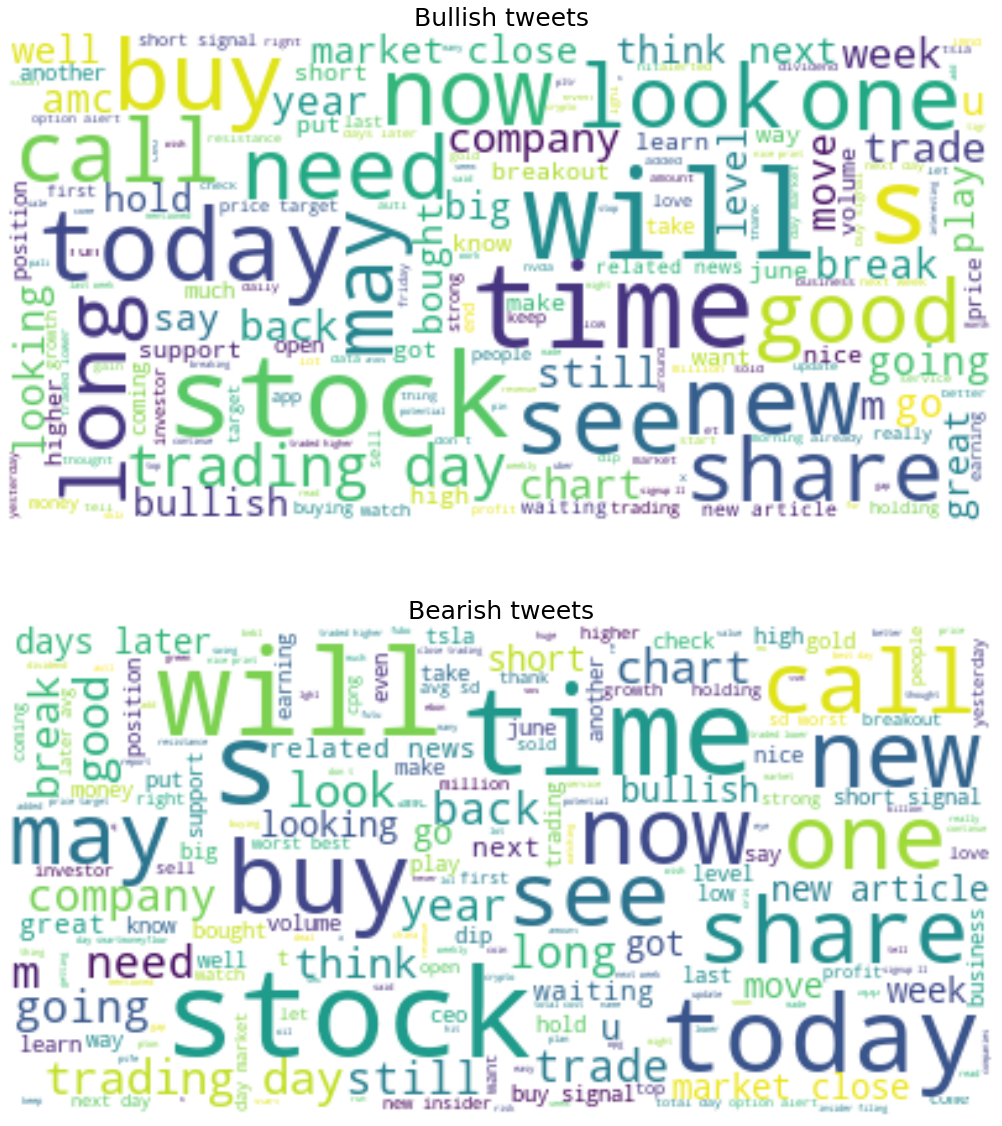

In [11]:
bullish_wordcloud = get_wordcloud(bullish_tweets)
bearish_wordcloud = get_wordcloud(bearish_tweets)

fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].imshow(bullish_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title("Bullish tweets", fontsize=25)

ax[1].imshow(bearish_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title("Bearish tweets", fontsize=25)
plt.show()

While bullish tweets have some prominent phrases like 'long', 'good', 'buy' and 'breakout', bearish tweets does not seem to have any prominent phrases that suggests a more negative sentiment except that the corresponding positive phrases are less prominent in bearish tweets
<br><br>
Regardless, there are still phrases like 'short' in bearish tweets that signify a more bearish sentiment on the tweets. It may still be fruitful to try training a classifier to classify these tweets

# Training a binary classifier
Using these labelled tweets, we can try to train a classifier. We will try two approaches here:
1. Converting the corpus to a bag of words model and passing it to a classifier
2. Use a embedding layer to convert each tweet into a sequence of vectors and pass it to a convolution neural network

#### Preparing data for training
Given that we are trying to train a binary classifier, it is important that the two classes have the same number of samples. However, this is not the case with our data. We will downsample the classes to have the same size for a balanced dataset. We will also prepare our train and test datasets here so that all our models can be tested against the same data

We will also perform some further cleaning on the text to remove noises

In [12]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# We will just get the lemma form of each word for now
def further_clean(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

example = """$rlx deadline reminders: kessler topaz meltzer check, llp reminds investors of
             securities fraud class action lawsuit filed against rlx technology inc. (rlx) ://"""
further_clean(example)

'$ rlx deadline reminder : kessler topaz meltzer check , llp reminds investor of security fraud class action lawsuit filed against rlx technology inc. ( rlx ) : //'

In [13]:
df.tweet = df.tweet.apply(further_clean)

<AxesSubplot:xlabel='bullish', ylabel='count'>

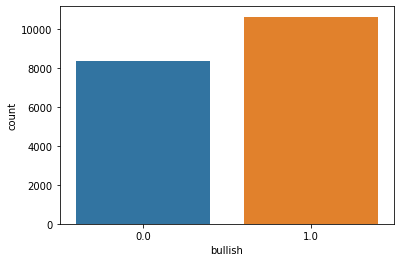

In [14]:
sns.countplot(x='bullish', data=df)

In [15]:
bullish_tweets = df.loc[df.bullish == 1]
bearish_tweets = df.loc[df.bullish == 0]
sample_size = min(len(bullish_tweets), len(bearish_tweets))
print(f"Sample size for each label is: {sample_size}")

Sample size for each label is: 8345


In [16]:
# Join equal number of bullish and bearish labelled tweets and reshuffle
train_df = pd.concat([
    bullish_tweets.sample(n=sample_size, random_state=42),
    bearish_tweets.sample(n=sample_size, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

train_df

,date,symbol,tweet,id,bullish
0,2021-06-04,FAMI,$ fami the actual handle of the cup is forming...,1400814011860533251,0.0
1,2021-06-14,VRM,"$ vrm announces proposed $ 500,000,000 convert...",1404535223547662336,1.0
2,2021-06-02,NRZ,$ nrz strong buy signal on the chart.// ; .,1399887407407931392,0.0
3,2021-05-26,ARKK,for those who followed me into the $ arkk trad...,1397548077364428802,1.0
4,2021-06-08,SOS,"can ’ t always be right , just hoping your $ 2...",1402265102645141507,0.0
...,...,...,...,...,...
16685,2021-05-21,CCL,$ ccl 30c exp:15-oct-21 ↑ 🚀 total ( day ) : $ ...,<NA>,0.0
16686,2021-05-21,BNGO,👀had me at # saphyr # ogm $ bngo # cytopia,<NA>,0.0
16687,2021-06-01,JD,$ jd trading like they ’ re gon na double the ...,1399723016158859270,1.0
16688,2021-05-27,HAE,$ hae # stockmarket # haemonetics reported fin...,1397854727665184774,1.0


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['tweet'], train_df['bullish'],
                                                    test_size=0.2, random_state=42)

### 1. Bag of words model with LinearSVC classifier
We will convert each tweet into a vector using a TFIDF-Vectorizer, and pass the vector as the feature for the classifier

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_svm = vectorizer.fit_transform(X_train)

classifier = LinearSVC(max_iter=5000)
classifier.fit(X_train_svm, y_train)

y_pred = classifier.predict(vectorizer.transform(X_test))
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  61.29418813660875


Using a LinearSVC classifier, we have a accuracy of about 60%, which is rather mediocre for a binary classification problem.
<br>
Let us see if we can improve the accuracy slightly by optimising the number of features of the vectorizer.

In [19]:
# Returns the accuracy of training a LinearSVC on the data given
# the num of features to limit in the Tfidf Vectorizer
def get_accuracy(num_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=num_features)
    X_train_svm = vectorizer.fit_transform(X_train)
    classifier = LinearSVC(max_iter=5000)
    classifier.fit(X_train_svm, y_train)
    y_pred = classifier.predict(vectorizer.transform(X_test))
    return accuracy_score(y_test, y_pred) * 100

In [20]:
accuracy_against_features = pd.DataFrame(columns = ['num_features', 'accuracy'])
min_features = 259000
max_features = 260000
step = 50
for index, feature in enumerate(range(min_features, max_features, step)):
    accuracy_against_features.loc[index] = [feature, get_accuracy(feature)]

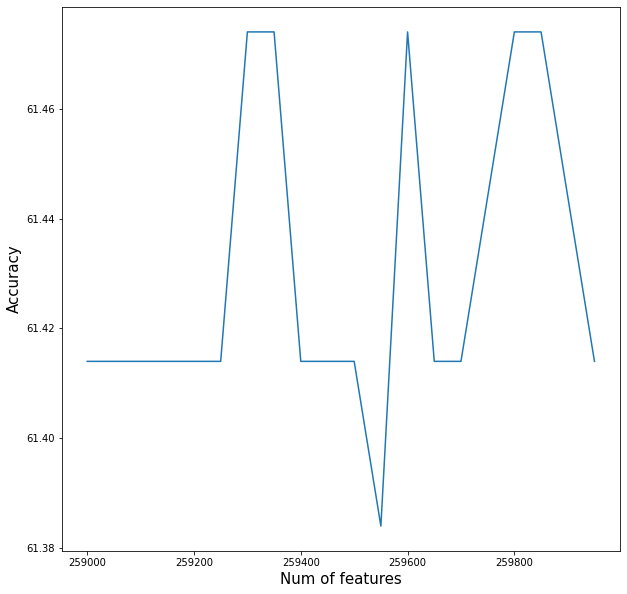

In [21]:
num_features = accuracy_against_features['num_features']
accuracies = accuracy_against_features['accuracy']

plt.figure(figsize=(10, 10))
plt.plot(num_features, accuracies)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Num of features", fontsize=15)
plt.show()

In [22]:
max_row = accuracy_against_features.loc[accuracies.idxmax()]
print(f"Max accuracy is {max_row.accuracy} with {max_row.num_features} features")

Max accuracy is 61.47393648891551 with 259300.0 features


With a LinearSVC classifier, we can only get up to 60% accuracy. Again, this is not exactly desirable for a binary classification problem. However, given that the labelling of the data may not be highly intuitive, this accuracy may show that such labelling could be effective
<br><br>
Let us train a model with the number of features with the highest accuracy for later use

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=int(max_row.num_features))
X_train_svm = vectorizer.fit_transform(X_train)

svm_classifier = LinearSVC(max_iter=5000)
svm_classifier.fit(X_train_svm, y_train)

LinearSVC(max_iter=5000)

### 2. CNN using word embeddings
We will convert each tweet into sequence of equal length vectors and pass them into a neural network. We will use the 1D CNN as our main model

<AxesSubplot:xlabel='tweet', ylabel='Count'>

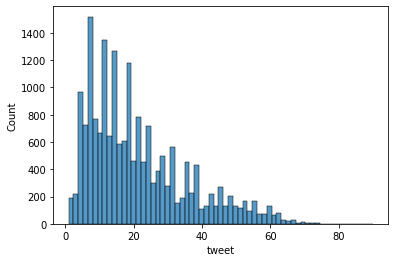

In [24]:
word_len = df.tweet.apply(lambda text: len(text.split()))
sns.histplot(word_len)

Most tweets have rather short sentences. We will set a max length of 50 which can accomodate most of the tweets. 
<br>
We will define an encoder layer that will take in our variable length tweets and pad/truncate them into integer sequences of length 50

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_len = 50
encoder = TextVectorization(output_sequence_length=max_len,
                            standardize=None)

# Fit the encoder on our training set
encoder.adapt(X_train.to_numpy())

Here, we will define a CNN with 1D convolutions and max pooling layers and train this model with our data. The encoder will serve to preprocess our variable length tweets into equal length integer sequences, which will then be passed into the embedding layers to become vectors with 16 dimensions

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense

vocab_size = len(encoder.get_vocabulary())

model = Sequential([
    encoder,
    Embedding(input_dim=vocab_size + 1, output_dim=16),
    Conv1D(32, 4, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.5),
    Conv1D(16, 2, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
history = model.fit(X_train, y_train, epochs=16, validation_split=0.2)

Epoch 1/16
334/334 [==============================] - 4s 9ms/step - loss: 0.6936 - accuracy: 0.5031 - val_loss: 0.6944 - val_accuracy: 0.4916
Epoch 2/16
334/334 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.5022 - val_loss: 0.6958 - val_accuracy: 0.4916
Epoch 3/16
334/334 [==============================] - 2s 7ms/step - loss: 0.6933 - accuracy: 0.5136 - val_loss: 0.6924 - val_accuracy: 0.5125
Epoch 4/16
334/334 [==============================] - 2s 7ms/step - loss: 0.6715 - accuracy: 0.5923 - val_loss: 0.6863 - val_accuracy: 0.5586
Epoch 5/16
334/334 [==============================] - 2s 7ms/step - loss: 0.5946 - accuracy: 0.6924 - val_loss: 0.6913 - val_accuracy: 0.5724
Epoch 6/16
334/334 [==============================] - 2s 7ms/step - loss: 0.4923 - accuracy: 0.7619 - val_loss: 0.7572 - val_accuracy: 0.5683
Epoch 7/16
334/334 [==============================] - 2s 7ms/step - loss: 0.4221 - accuracy: 0.8142 - val_loss: 0.7842 - val_accuracy: 0.5556
Epoch 

There is a clear overfitting of the model to the training set despite the multiple dropout layers. This could be due to the small sample size we have that causes the model to memorize the patterns in the training set. Regardless, the validation accuracy is still rather low, hitting the peak at about 57%. Let's see how the model performs against the unseen test set

In [29]:
metrics = model.evaluate(X_test, y_test)
print(f"Accuracy on test set: {metrics[1] * 100}")

105/105 [==============================] - 0s 2ms/step - loss: 1.4186 - accuracy: 0.5773
Accuracy on test set: 57.72917866706848


Since the LinearSVC classifier seems to perform slightly better than the CNN model, let's try some predictions from our SVC model





In [30]:
def svm_predict(text):
    vector = vectorizer.transform([text])
    return 'bullish' if svm_classifier.predict(vector)[0] == 1 else 'bearish'

In [31]:
examples =["What a demo! Wow, they’re going all out here! $PLTR",
           "$AMD Looking for a run up past 85 to 88. Needs to get over the res at 83.",
           "Is that bottom on $TLRY ?",
           "$TSLA Descending triangle in the make..."]

for text in examples:
    print(f"Text: {text}")
    print(f"Prediction: {svm_predict(text)}")
    print("================================")

Text: What a demo! Wow, they’re going all out here! $PLTR
Prediction: bullish
Text: $AMD Looking for a run up past 85 to 88. Needs to get over the res at 83.
Prediction: bullish
Text: Is that bottom on $TLRY ?
Prediction: bearish
Text: $TSLA Descending triangle in the make...
Prediction: bearish


### Exporting the model
Despite the low accuracies, the prediction still seems to make sense. The LinearSVC classifier might be useful if used to analyse a bunch of tweets and to gather their average sentiments instead of being used on individual ones. The accuracy will be worked on further as more data is available.
<br><br>
For now, we will save this model for future use.

In [32]:
from joblib import dump, load

# Save both the classifier and vectorizer
dump(svm_classifier, 'svm_classifier.joblib')
dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [33]:
# Check that we can load the classifiers and vectorizers back
saved_classifier = load("svm_classifier.joblib")
saved_vectorizer = load("vectorizer.joblib")

In [34]:
y_pred = saved_classifier.predict(saved_vectorizer.transform(X_test))
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  61.47393648891551
